In [7]:
import csv
import re
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..") # adds higher directory to python modules path

from LoaderPACK.Unet_leaky import Unet_leaky
from LoaderPACK.Loader import load_whole_data, load_shuffle_5_min
import torch

In [8]:
def lorenz_curve(ls: list, name: str):
    tot_sum = sum(ls) # get the total sum of intervals
    nr_patients = len(ls)
    sorted_ls = sorted(ls)
    
    res = []
    rang = [i/100 for i in range(0, 100 + 5, 5)]
    for per in rang:
        res.append(sum(sorted_ls[:math.floor(nr_patients * per)])/tot_sum)
    
    plt.title(f"Lorenz Curve of {name}")
    plt.xlabel("Cummulative % of patients")
    plt.ylabel("Cummulative % of intervals")
    plt.plot(rang, res)
    plt.plot(rang, rang)
    return plt

In [9]:
path = "C:/Users/Marc/Desktop/model_data/train_model_data"

patient_samples = dict()

with open(path + '/train_encoding.csv', 'r') as file:
    ls = csv.reader(file)
    for rows in ls:
        m = re.match(r".+/\d+/(\d+)/+.", rows[0])
        val_to_dict = patient_samples.get(m.group(1), [])
        val_to_dict.append(rows[2])
        patient_samples[m.group(1)] = val_to_dict

In [10]:
print(patient_samples)

{'00000297': ['1'], '00000906': ['2', '3', '4'], '00001154': ['5'], '00001402': ['6'], '00002272': ['7'], '00002348': ['8', '9', '10'], '00002508': ['11'], '00002991': ['12'], '00003363': ['13'], '00003573': ['14'], '00004526': ['15', '16'], '00004586': ['17'], '00004625': ['18'], '00005230': ['19', '20'], '00005400': ['21'], '00005457': ['22'], '00005740': ['23', '24'], '00006052': ['25'], '00006091': ['26', '27'], '00006224': ['28'], '00006319': ['29'], '00006440': ['30', '31', '32', '33', '34'], '00006510': ['35'], '00006531': ['36', '37', '38', '39'], '00006535': ['40', '41', '42', '43', '44'], '00006566': ['45'], '00006598': ['46'], '00006835': ['47'], '00006847': ['48'], '00006880': ['49', '50', '51'], '00007020': ['52'], '00007182': ['53'], '00007372': ['54'], '00007481': ['55', '56'], '00007647': ['57'], '00007679': ['58'], '00007724': ['59'], '00007755': ['60'], '00007793': ['61'], '00007823': ['62'], '00007824': ['63'], '00007852': ['64'], '00007870': ['65'], '00007920': ['66

Plot the experiment from a patient:

In [11]:
device = "cpu"

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)
it = iter(trainloader)
model_input, model_target, model_data = next(it)

torch.set_printoptions(edgeitems=2)

print(model_input[0])

print()

print(model_target[0])

tensor([[ 0.0601, -3.4870,  ..., -0.6444, -0.1669],
        [-0.9249,  5.6028,  ..., -0.4507, -0.1218],
        [ 2.3317, -5.0536,  ...,  0.7382,  0.1175],
        [ 0.9897, -7.1149,  ...,  1.3465,  0.1151]])

tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])


The data that is fed into the model, can be seen below:

In [12]:
device = "cpu"

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)
it = iter(trainloader)

batch_size = 1
loader2 = load_shuffle_5_min(next(it), device)
loader2 = torch.utils.data.DataLoader(loader2,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=0)

it2 = iter(loader2)
model_input, model_target, model_data = next(it2)

torch.set_printoptions(edgeitems=2)

print(model_input[0][0])

print(model_target[0][0])

tensor([  3.2498,   4.5258,  ...,   6.9581, -11.2944])
tensor([0., 0.,  ..., 0., 0.])


In [13]:
import time


device = "cpu"
print(device)

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_before = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    size = (file[0][0].shape[0], file[0][0].shape[1])
    length = math.floor(((size[1]-200*30)/(200*60*5)))*size[0] # the amount of total possible cuts
    
    data_before.append(length)

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)



cpu
time: 14.21156620979309
Number of files loaded in total: 0


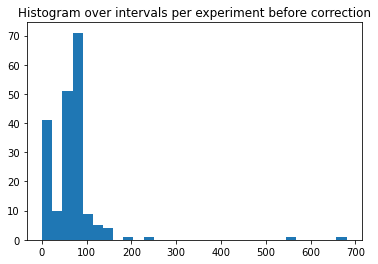

74.35384615384615
66.0


In [14]:
plt.hist(data_before, bins = 30)
plt.title("Histogram over intervals per experiment before correction")
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_exp_before.jpg")
plt.show()
plt.close()


print(np.mean(data_before))
print(np.median(data_before))

In [15]:
patient_before = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_before[int(i)-1]
    
    patient_before.append(vals)

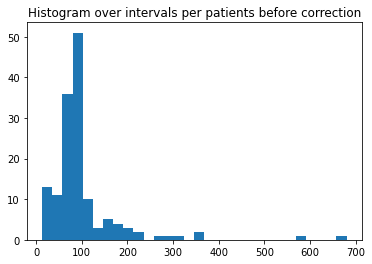

99.99310344827586
88.0


In [16]:
plt.hist(patient_before, bins = 30)
plt.title("Histogram over intervals per patients before correction")
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_patient_before.jpg")
plt.show()
plt.close()

print(np.mean(patient_before))
print(np.median(patient_before))

In [17]:
sorted_patient_before = sorted(patient_before, reverse=True)
print("number of patients:", len(patient_before))
print(int(0.25*len(patient_before)))
sum(sorted_patient_before[:int(0.25*len(patient_before))])/sum(patient_before)

number of patients: 145
36


0.4845161735292089

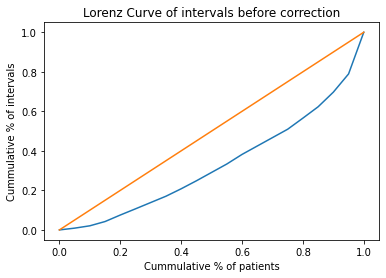

In [18]:
m = lorenz_curve(patient_before, "intervals before correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_before.jpg")
plt.show()
plt.close()


In [20]:
import time


device = "cpu"
print(device)

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_after = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    loader2 = load_shuffle_5_min(file, device)
    loader2 = torch.utils.data.DataLoader(loader2,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0)
    nr_of_files_loaded += 1
    j = 0
    for i in loader2:
        j += 1
    
    data_after.append(j)

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)


cpu
time: 15.824683666229248
Number of files loaded in total: 195


In [32]:
patient_after = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_after[int(i)-1]
    
    patient_after.append(vals)

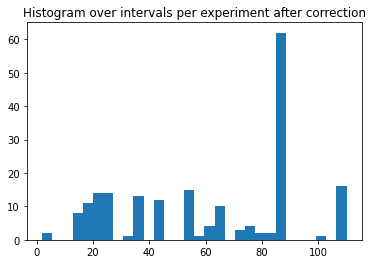

61.3948717948718
64.0


In [33]:
plt.title("Histogram over intervals per experiment after correction")
plt.hist(data_after, bins = 30)
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_exp_after.jpg")
plt.show()
plt.close()

print(np.mean(data_after))
print(np.median(data_after))

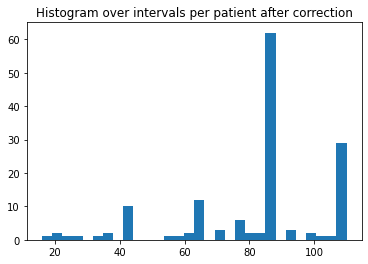

82.56551724137931
88.0


In [34]:
plt.title("Histogram over intervals per patient after correction")
plt.hist(patient_after, bins = 30)
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_patient_after.jpg")
plt.show()
plt.close()



print(np.mean(patient_after))
print(np.median(patient_after))

In [29]:
sorted_patient_after = sorted(patient_after, reverse=True)
print("number of patients:", len(patient_after))

number of patients: 145


In [30]:
int(0.25*len(patient_after))

36

In [31]:
sum(sorted_patient_after[:int(0.25*len(patient_after))])/sum(patient_after)

0.3220013364517207

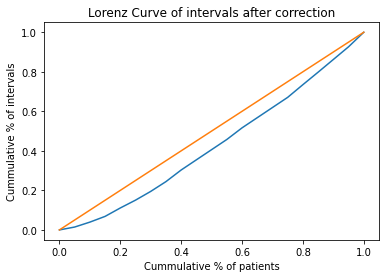

In [27]:
m = lorenz_curve(patient_after, "intervals after correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_after.jpg")
plt.show()
plt.close()

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import numpy as np
import math
import pickle

class load_shuffle_5_min(Dataset):
    """
    This dataloader loads the tensor input and target in whole
    """
    def __init__(self, ls: list, device):
        """
        Args:
            path (str): path to the input & target folder.
            ind (list): list of indices for which pictures to load.
            device (class 'torch.device'): which pytorch device the data should
            be sent to.
        """

        self.device = device
        self.ls = ls # list with the input and target data
        self.size = (ls[0][0].shape[0], ls[0][0].shape[1])
            # size of target and input

        self.s_len = ls[2][0]
        self.s_num = ls[2][1]

        length = math.floor((self.size[1]/(200*60*5)))*self.size[0]
            # the amount of total possible cuts

        self.length = int(min(torch.div(10, self.s_num,
                                        rounding_mode='trunc'), length))
            # make sure that no more than 75 samples is taken from the same
            # individual

        self.gen = iter(self.create_data(self.length))


    def create_data(self, nr_of_cuts):
        cut_point = np.random.randint(low = 200*30, #remove the first 30 secs
                            high = self.size[1] - 5*200*60, size = nr_of_cuts)
                            # choose the place to cut

        cuts_pr_chan = nr_of_cuts/self.ls[0][0].shape[0]
            # the amount of cuts pr channel

        for i in range(nr_of_cuts):
            chan = int(i//cuts_pr_chan) # the given channel
            inp = self.ls[0][0][chan][cut_point[i]:cut_point[i]+60*5*200].view(1, 60*5*200)
            tar = self.ls[1][0][chan][cut_point[i]:cut_point[i]+60*5*200].view(1, 60*5*200)
            #inp = self.ls[0][0][chan][cut_point[i]:cut_point[i]+60*5*200]
            #tar = self.ls[1][0][chan][cut_point[i]:cut_point[i]+60*5*200]


            #tar = torch.cat((tar[0], -1*(tar[0] - 1))).view(2, 60*5*200)
            yield (inp, tar, chan)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        inp, tar, chan = next(self.gen)
        inp = inp.to(self.device)
        tar = tar.to(self.device)
        return inp, tar, chan

In [ ]:
import time


device = "cpu"
print(device)

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_very_low = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    loader2 = load_shuffle_5_min(file, device)
    loader2 = torch.utils.data.DataLoader(loader2,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0)
    nr_of_files_loaded += 1
    j = 0
    for i in loader2:
        j += 1
    
    data_very_low.append(j)

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)




In [ ]:
patient_low = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_very_low[int(i)-1]
    
    patient_low.append(vals)

In [ ]:
m = lorenz_curve(patient_low, "intervals with extreme correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_low.jpg")
plt.show()
plt.close()

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import numpy as np
import math
import pickle

class load_whole_data(Dataset): # Dataset
    """
    This dataloader loads the tensor input and target in whole
    """
    def __init__(self, path: str, ind: list, series_dict = None):
        """
        Args:
            path (str): path to the input & target folder.
            ind (list): list of indices for which pictures to load.
            device (class 'torch.device'): which pytorch device the data should
            be sent to.
        """

        self.device = "cpu"
        self.imgs_path = path

        if series_dict:
            with open(path + "/" + series_dict, 'rb') as handle:
                self.s_dict = pickle.load(handle)
        else:
            self.s_dict = False

        self.data = []
        for i in ind:
            self.data.append([self.imgs_path + f"/model_input ({i}).pt",
                        self.imgs_path + f"/model_target ({i}).pt",
                        self.s_dict[i] if self.s_dict else 0])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_path, target_path, s_len_ls = self.data[idx]
                                # path for target + input + lenght of series

        inp = torch.load(input_path) # load the input data
        inp = inp.type(torch.float).to(self.device)

        tar = torch.load(target_path) # load the target data
        tar = tar.type(torch.float).to(self.device)

        return inp, tar, s_len_ls
    
        def yeet(self):
            return iter(self.data)


    
class train_loader(Dataset):
    """
    This dataloader loads the tensor input and target in whole
    """
    def __init__(self, device, path: str, ind: list, series_dict = None):

        self.imgs_path = path
        self.device = device

        if series_dict:
            with open(path + "/" + series_dict, 'rb') as handle:
                self.s_dict = pickle.load(handle)
        else:
            self.s_dict = False

        self.data = []
        for i in ind:
            self.data.append([self.imgs_path + f"/model_input ({i}).pt",
                        self.imgs_path + f"/model_target ({i}).pt",
                        self.s_dict[i] if self.s_dict else 0])
        
        self.infin_it = self.infin_iter()
        
        self.read = self.reader()
        
            
    def infin_iter(self):
        it = iter(self.data)
        while True:
            try:
                yield next(it)
            except KeyboardInterrupt:
                print('Interrupted')
                try:
                    sys.exit(0)
                except SystemExit:
                    os._exit(0)

            except:
                it = iter(self.data)
        
    def reader(self):
        while True:
            input_path, target_path, s_len_ls = next(self.infin_it)
            print(input_path)
                                    # path for target + input + lenght of series

            inp = torch.load(input_path) # load the input data
            inp = inp.type(torch.float).to("cpu")

            tar = torch.load(target_path) # load the target data
            tar = tar.type(torch.float).to("cpu")
            self.ls = (inp, tar, s_len_ls)


            self.size = (self.ls[0].shape[0], self.ls[0].shape[1])
                # size of target and input

            self.s_len = self.ls[2][0]
            self.s_num = self.ls[2][1]

            length = math.floor((self.size[1]/(200*60*5)))*self.size[0]
                # the amount of total possible cuts

            # self.length = int(min(torch.div(110, self.s_num,
            #                                 rounding_mode='trunc'), length))


            gen = self.create_data(3)

            for g in gen:
                print(g)
                yield g


    def create_data(self, nr_of_cuts):
        cut_point = np.random.randint(low = 200*30, #remove the first 30 secs
                            high = self.size[1] - 5*200*60, size = nr_of_cuts)
                            # choose the place to cut

        cuts_pr_chan = nr_of_cuts/self.ls[0].shape[0]
        
            # the amount of cuts pr channel
        
        
        for i in range(nr_of_cuts):
            chan = int(i//cuts_pr_chan) # the given channel
            
            inp = self.ls[0][chan][cut_point[i]:cut_point[i]+60*5*200].view(1, 60*5*200)
            tar = self.ls[1][chan][cut_point[i]:cut_point[i]+60*5*200].view(1, 60*5*200)

            yield (inp, tar, chan)
            
    def __getitem__(self, idx):
        inp, tar, chan = next(self.read)
        inp = inp.to(self.device)
        tar = tar.to(self.device)
        return inp, tar, chan
    
    def __len__(self):
        return 7



    

                

In [ ]:
import time


device = "cpu"
print(device)

trainload = train_loader(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 3 + 1)], device = device)

# Set up the dataloaders:


batch_size = 4

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=batch_size,
                                          drop_last = True,
                                          num_workers=0)

data_after = []

nr_of_files_loaded = 0


start = time.time()

for file in trainloader:
    print(file[0].shape)
    print(file)

print("time:", time.time()-start)
    

In [ ]:
class A:
    def __init__(self):
        self.r = range(10)
        self.it = iter(self.r)

    def __getitem__(self, idx):
        return next(self.it)

        
    
    def __iter__(self):
        return iter(self.it)
    

In [ ]:
a = A()
b = iter(a)

In [ ]:
class B(A):
    def __init__(self): #, ls: list, 
        super().__init__()
        for i in self.__iter__():
            print(i)

In [ ]:
b = B()

In [ ]:
kk = iter([1, 2, 3, 4, 5])

In [ ]:
next(kk)

In [ ]:
import time


device = "cpu"
print(device)

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_after = []

nr_of_files_loaded = 0

batch_size = 20

start = time.time()

for file in trainloader:
    loader2 = load_shuffle_5_min(file, device)
    loader2 = torch.utils.data.DataLoader(loader2,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0)
    nr_of_files_loaded += 1
    j = 0
    for i in loader2:
        print(i[0].shape)
    
    data_after.append(j)

print("time:", time.time()-start)
    

